## Analysis of an E-commerce Dataset Part 3 (s2 2023)

In this Portfolio task, my objective is to develop predictive models for 'rating' based on various features in the dataset, where 'rating' is converted to binary values: 1 for 'like' and 0 for 'dislike'. Here's a breakdown of the steps I'll follow:

- Data Exploration and Cleaning: I'll start by exploring the dataset, checking for any anomalies or missing values, and cleaning the data if necessary. This may involve removing abnormal instances and handling missing values appropriately.
- Feature Encoding: Next, I'll convert categorical features into numerical features using an encoder, as many machine learning models require numerical input.
- Correlation Analysis: I'll examine the correlation between different features to understand their relationships and potential impact on the target variable ('rating').
- Logistic Regression Model: I'll split the dataset into training and testing sets and train a logistic regression model to predict 'rating' based on other features. I'll evaluate the accuracy of this model.
- K-Nearest Neighbors (KNN) Model: Similarly, I'll split the dataset and train a KNN model to predict 'rating'. I'll initially set the value of K arbitrarily. Then, I'll evaluate the accuracy of this model.
- Hyperparameter Tuning for KNN: To improve the KNN model's performance, I'll tune the hyperparameter K using techniques like grid search or cross-validation. This step will help me understand how different values of K influence prediction performance.

Throughout this process, I'll document my steps and findings in the notebook, ensuring clarity and readability. Lastly, I'll discuss the performance of both the Logistic Regression and KNN models, highlighting their strengths and weaknesses in solving the classification problem.

# Importing Libraries and assets

In [ ]:
#Importing Libraries and assets
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier


# 1. Exploring & Cleaning Our Data
first we explore data to understand it better, then check for abnormal values

In [ ]:
ecomdata = pd.read_csv("portfolio_3.csv")
ecomdata.head(10)

,userId,timestamp,review,item,helpfulness,gender,category,item_id,item_price,user_city,rating
0,4081,71900,Not always McCrap,McDonald's,3,M,Restaurants & Gourmet,41,30.74,4,1
1,4081,72000,I dropped the chalupa even before he told me to,Taco Bell,4,M,Restaurants & Gourmet,74,108.30,4,0
2,4081,72000,The Wonderful World of Wendy,Wendy's,4,M,Restaurants & Gourmet,84,69.00,4,1
3,4081,100399,They actually did it,"South Park: Bigger, Longer & Uncut",3,M,Movies,68,143.11,4,1
4,4081,100399,Hey! Gimme some pie!,American Pie,3,M,Movies,6,117.89,4,0
5,4081,100399,Good for sci-fi,Matrix,3,M,Movies,40,24.51,4,0
6,4081,100399,Scary? you bet!,Blair Witch Project,3,M,Movies,12,44.00,4,1
7,4081,101899,Fox - the 4th basic channel,FOX,4,M,Media,25,80.00,4,1
8,4081,112099,Amen!,Dogma,3,M,Movies,22,87.59,4,1
9,4081,122899,mama mia!,Olive Garden,3,M,Restaurants & Gourmet,49,32.00,4,1


In [ ]:
ecomdata.shape

(2685, 11)

## 1.1 Checking for missing & duplicate values as well as outliers

In [ ]:
ecomdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   userId       2685 non-null   int64  
 1   timestamp    2685 non-null   int64  
 2   review       2685 non-null   object 
 3   item         2685 non-null   object 
 4   helpfulness  2685 non-null   int64  
 5   gender       2685 non-null   object 
 6   category     2685 non-null   object 
 7   item_id      2685 non-null   int64  
 8   item_price   2685 non-null   float64
 9   user_city    2685 non-null   int64  
 10  rating       2685 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 230.9+ KB


**There no null values in our dataset**

In [ ]:
#counting number of duplicate rows in our dataset
ecomdata.duplicated().sum()

0

**There are no duplicates in our dataset**

**now let's check for outliers**

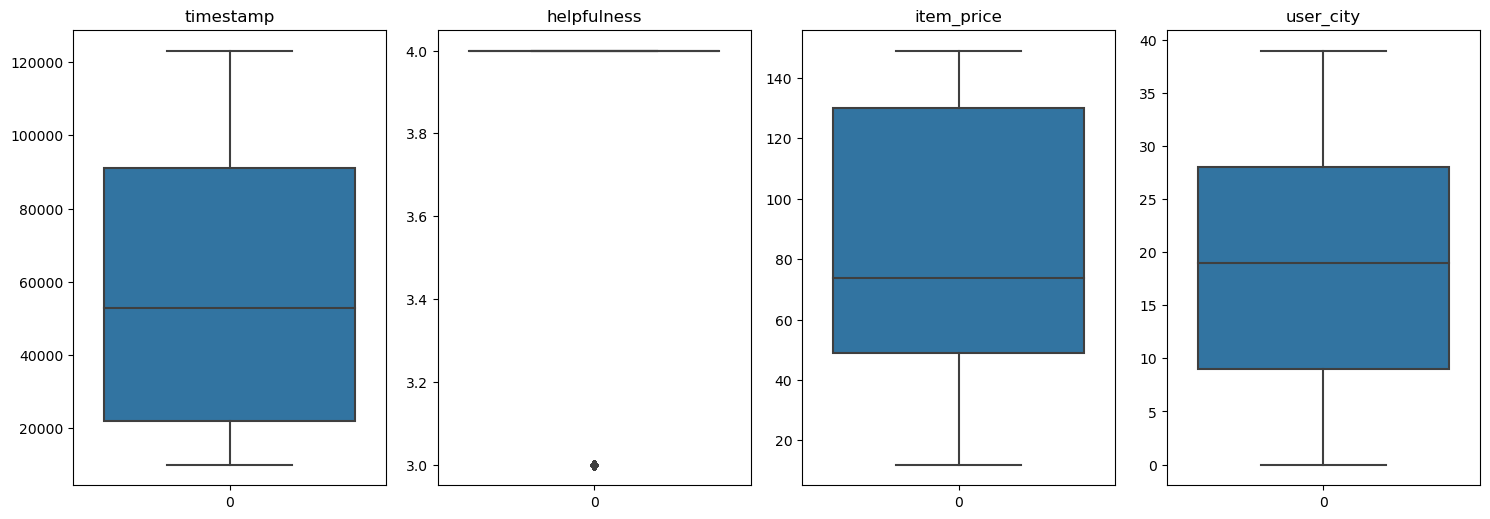

In [ ]:
plt.figure(figsize=(15, 10))

# Plot boxplots for each numerical column
numerical_columns = ['timestamp', 'helpfulness', 'item_price', 'user_city']
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data=ecomdata[col])
    plt.title(col)

plt.tight_layout()
plt.show()

- timestamp: No apparent outliers.
- helpfulness: most of the values are around 4, there are possible outliers we need further analysis.
- item_id: Uniformly distributed, no visible outliers.
- item_price: no visible outliers.
- user_city: Uniformly distributed, no visible outliers.

In [ ]:
ecomdata['helpfulness'].describe()

count    2685.000000
mean        3.908007
std         0.289069
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: helpfulness, dtype: float64

**there are outliers for helpfulness so i cleared them**

In [ ]:
# Calculate IQR
Q1 = ecomdata['helpfulness'].quantile(0.25)
Q3 = ecomdata['helpfulness'].quantile(0.75)
IQR = Q3 - Q1

# bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
data_clean = ecomdata[(ecomdata['helpfulness'] >= lower_bound) & (ecomdata['helpfulness'] <= upper_bound)]

# Display the shape of the original and cleaned data
original_shape = ecomdata.shape
cleaned_shape = data_clean.shape

original_shape, cleaned_shape


((2685, 11), (2438, 11))

# 2. Encoding and converting categorical data
The categorical variables are review, item, gender and category
I used Label Encoding that assigns integers to different categories

In [ ]:
# List of categorical features to encode
categorical_features = ['review', 'item', 'gender', 'category']

# Apply LabelEncoder on categorical features
for feature in categorical_features:
    data_clean[feature] = encoder.fit_transform(data_clean[feature])

# Display the first few rows of the dataset after encoding
data_clean.head()


/var/folders/zg/n55613c165571_84fgh2td8h0000gn/T/ipykernel_13226/3374948622.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean[feature] = encoder.fit_transform(data_clean[feature])
/var/folders/zg/n55613c165571_84fgh2td8h0000gn/T/ipykernel_13226/3374948622.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean[feature] = encoder.fit_transform(data_clean[feature])
/var/folders/zg/n55613c165571_84fgh2td8h0000gn/T/ipykernel_13226/3374948622.py:6: SettingWithCopyWarning: 
A value is trying t

,userId,timestamp,review,item,helpfulness,gender,category,item_id,item_price,user_city,rating
1,4081,72000,1015,67,4,1,8,74,108.30,4,0
2,4081,72000,2000,77,4,1,8,84,69.00,4,1
7,4081,101899,731,23,4,1,4,25,80.00,4,1
11,4159,22304,834,45,4,1,8,50,25.00,10,1
12,4159,60203,232,29,4,1,6,32,100.62,10,1


# 3. Further Analysing Data for Correlation
we check data to see our correlations

In [ ]:
data_clean.corr()

,userId,timestamp,review,item,helpfulness,gender,category,item_id,item_price,user_city,rating
userId,1.000000,-0.070805,0.006841,-0.012785,NaN,-0.038536,-0.054610,-0.012764,0.022551,-0.058863,0.070893
timestamp,-0.070805,1.000000,-0.006058,-0.002174,NaN,-0.005701,0.011962,-0.003594,0.020206,-0.011367,0.001893
review,0.006841,-0.006058,1.000000,0.173289,NaN,-0.036737,0.011270,0.173589,-0.039548,0.049058,-0.037373
item,-0.012785,-0.002174,0.173289,1.000000,NaN,0.000201,-0.049368,0.999765,-0.058070,-0.001116,0.058499
helpfulness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,-0.038536,-0.005701,-0.036737,0.000201,NaN,1.000000,0.022965,0.000703,-0.051869,-0.068108,-0.019109
category,-0.054610,0.011962,0.011270,-0.049368,NaN,0.022965,1.000000,-0.048688,-0.111538,-0.001592,-0.146022
item_id,-0.012764,-0.003594,0.173589,0.999765,NaN,0.000703,-0.048688,1.000000,-0.062491,-0.001383,0.057821
item_price,0.022551,0.020206,-0.039548,-0.058070,NaN,-0.051869,-0.111538,-0.062491,1.000000,-0.025975,0.012540
user_city,-0.058863,-0.011367,0.049058,-0.001116,NaN,-0.068108,-0.001592,-0.001383,-0.025975,1.000000,-0.023899


**This is not a visually pleasing way to showcase our data so i visualised my data for a better
view and understanding**

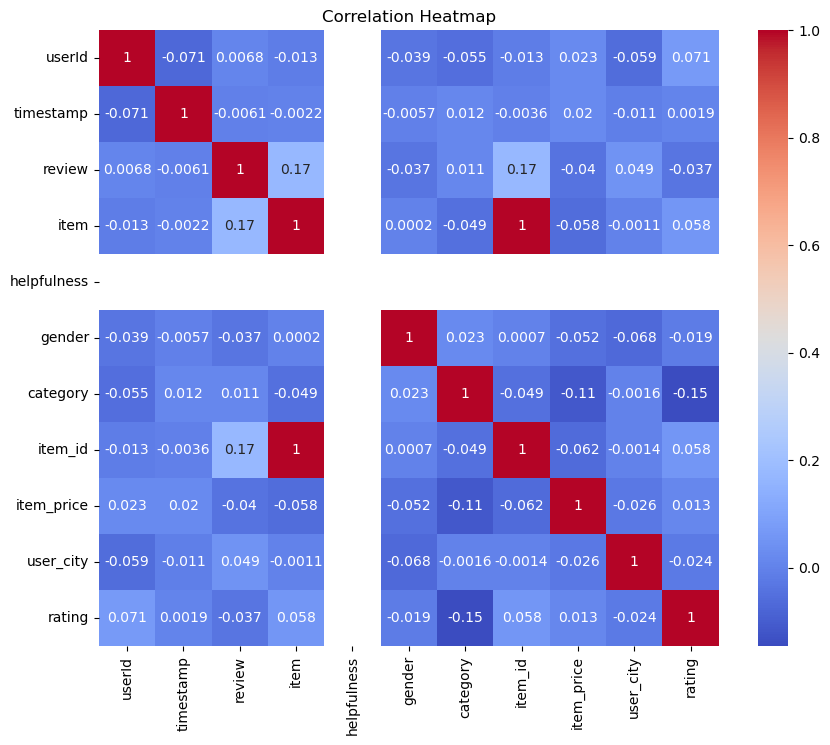

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_clean.corr(), annot=True, cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

**The correlation heatmap shows our target variable, does not have a very strong correlation with any of the features, even tho some features like category has a somewhat highter correlation I personally think its not enough so i train my models with all beside ofcourse rating**

# 4. Logistic Regression Model

In [ ]:
# X is assigned all the columns from the cleaned dataset except for rating which we are trying to predict.
# y is assigned the rating column, which is the variable we want to predict.
X = data_clean.drop(columns=['rating'])
y = data_clean['rating']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training LR model
# model will go through a maximum of 1000 iterations to find the optimal parameters.
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_logistic = logistic_model.predict(X_test)

# Calculate the accuracy of the LR model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)

accuracy_logistic


0.6495901639344263

# 5. KNN Model

In [ ]:
#Initializing and training our model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_knn = knn_model.predict(X_test)

# Calculate the accuracy of KNN model
accuracy_knn = accuracy_score(y_test, y_pred_knn)

accuracy_knn

0.5942622950819673

## 5.1 Fine Tuning our KNN Model
Tuning k helps achieve the best performance
- if k is low the model might be overinfluenced by the anomalies
- if k is high model can ignore details


In [ ]:
# Testing k from 1 to 50
k_values = list(range(1, 51)) 
# Initializing a list to store accuracy for different values of k
accuracy_list = []

# Loop over different values of k
for k in k_values:
    # Train the KNN model in a loop
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    
    # Make predictions on the testing set and calculate accuracy
    y_pred_knn = knn_model.predict(X_test)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    accuracy_list.append(accuracy_knn)

# Find the optimal k and corresponding accuracy without plotting
optimal_k= k_values[accuracy_list.index(max(accuracy_list))]
optimal_accuracy = max(accuracy_list)

print("best k value =", optimal_k_no_plot, "\naccuracy of best k value =", optimal_accuracy)



best k value = 47 
accuracy of best k value = 0.6495901639344263


**tuning k improved the accuracy from 59 to 64**

# 6. Comparing models

- Both Logistic Regression and KNN models have similar performance of 64 accuarcy on our dataset
- each model has their on pros and cons LR model is faster KNN can help us with more complex problems